# Factorization Machine
- Factorization Machine을 tensorflow 2.0으로 구현해봅니다
- 주어진 movie lens 데이터를 tensorflow에 적합하게 가공하고 예측 모델을 학습합니다
- 모델의 성능은 예측 성능인 RMSE로 평가합니다

## xlearn install
```
$ wget https://github.com/aksnzhy/xlearn/releases/download/v0.4.4/xlearn-0.4.4.tar.gz
$ pip install xlearn-0.4.4.tar.gz
```

In [ ]:
!wget https://github.com/aksnzhy/xlearn/releases/download/v0.4.4/xlearn-0.4.4.tar.gz

In [ ]:
!pip install xlearn-0.4.4.tar.gz

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.layers import Dense, Input, Add, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from datetime import datetime, date
from google.colab import drive
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import xlearn as xl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
K = tf.keras.backend
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 데이터 Preprocessing

In [4]:
# 평점 데이터, 영화 데이터, 유저 데이터를 모두 사용합니다

path = '/content/drive/MyDrive/recomm_study/recomm_code/Recommend_learningspoons/data/ml-100k-20220921T022842Z-001/ml-100k/'
ratings_df = pd.read_csv(path + 'u.data', sep='\t', encoding='latin-1', header=None)
movies_df = pd.read_csv(path + 'u.item', sep='|', encoding='latin-1', header=None)
users_df = pd.read_csv(path + 'u.user', sep='|', encoding='latin-1', header=None)

In [5]:
ratings_df.columns = ['user_id', 'movie_id', 'rating', 'timestamp']
movies_df.columns = ['movie_id', 'movie_title', 'release_date', 'video_release_date',
                     'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 
                     'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
                     'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
                     'Thriller', 'War', 'Western'] 
users_df.columns = ['user_id', 'age', 'gender', 'occupation', 'zip_code']   

In [6]:
def age_map(x):
    x = int(x)
    if x < 20:
        return '10'
    elif x >= 20 and x < 30:
        return '20'
    elif x >= 30 and x < 40:
        return '30'
    elif x >= 40 and x < 50:
        return '40'
    elif x >= 50 and x < 60:
        return '50'
    else:
        return '60'

users_df['age'] = users_df['age'].apply(lambda x: age_map(x))

In [7]:
print(users_df.shape)
users_df.head()

(943, 5)


,user_id,age,gender,occupation,zip_code
0,1,20,M,technician,85711
1,2,50,F,other,94043
2,3,20,M,writer,32067
3,4,20,M,technician,43537
4,5,30,F,other,15213


In [8]:
print(movies_df.shape)
movies_df.head()

(1682, 24)


,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [9]:
print(ratings_df.shape)
ratings_df.head()

(100000, 4)


,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [10]:
# users_df와 movies_df의 feature를 FM에 사용하기 위해 
# fm_df = ratings_df + movies_df + users_df

fm_df = pd.merge(ratings_df, movies_df, how='left', on='movie_id')
fm_df = pd.merge(fm_df, users_df, how='left', on='user_id')
fm_df = fm_df[    ['user_id', 'movie_id',
     'age', 'gender',
     'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
     'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western',
     'rating']]
print(fm_df.shape)
fm_df.head()

(100000, 24)


,user_id,movie_id,age,gender,unknown,Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,rating
0,196,242,40,M,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,3
1,186,302,30,F,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,3
2,22,377,20,M,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
3,244,51,20,M,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,2
4,166,346,40,M,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [11]:
# 모든 feature는 category형으로 변환
feature_list = ['user_id', 'movie_id', 'age', 'gender']

for feature in feature_list:
  fm_df[feature] = fm_df[feature].astype('category')

# user_id, movie_id, age, gender에 대한 매핑
# category형으로 형변환했으므로 원래 값을 key, 바뀐 값을 value로 
user_id_map = {value: idx for idx, value, in enumerate(fm_df['user_id'].cat.categories)}
movie_id_map = {value: idx for idx, value in enumerate(fm_df['movie_id'].cat.categories)}
gender_map = {value: idx for idx, value in enumerate(fm_df['gender'].cat.categories)}
age_map = {value: idx for idx, value in enumerate(fm_df['age'].cat.categories)}
genre_list = [
    'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
    'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
]

In [12]:
#gender_map
age_map

{'10': 0, '20': 1, '30': 2, '40': 3, '50': 4, '60': 5}

In [13]:
fm_df['user_id'] = fm_df['user_id'].cat.codes
fm_df['movie_id'] = fm_df['movie_id'].cat.codes
fm_df['gender'] = fm_df['gender'].cat.codes
fm_df['age'] = fm_df['age'].cat.codes
fm_df.head()

,user_id,movie_id,age,gender,unknown,Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,rating
0,195,241,3,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,3
1,185,301,2,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,3
2,21,376,1,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
3,243,50,1,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,2
4,165,345,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## FM 학습 데이터 생성

In [14]:
data = {'X' : [], 'y' : []}
# FM의 입력변수 개수
# 각 변수의 unique값을 다 더함
size_X = len(user_id_map) + len(gender_map) + len(age_map) + len(movie_id_map) + len(genre_list)

for _, row in tqdm(fm_df.iterrows()):
  x = [0] * size_X

  # user_variable
  idx = 0
  x[idx + row['user_id']] = 1
  idx += len(user_id_map)

  x[idx + row['gender']] = 1
  idx += len(gender_map)

  x[idx + row['age']] = 1
  idx += len(age_map)

  # movie_variable
  x[idx + row['movie_id']] = 1
  idx += len(movie_id_map)

  # genre feature는 multi-hot encoding
  x[idx : idx+len(genre_list)] = row[genre_list]
  data['X'].append(x)
  data['y'].append(row['rating'])
  
# X는 FM에 맞게 가공한 input variable의 numpy array
# y label은 rating
data['X'] = np.asarray(data['X'])
data['y'] = np.asarray(data['y'], dtype=np.float32)

0it [00:00, ?it/s]

In [15]:
print(size_X)
print(len(data['X'])) # 전체 데이터 개수
print(len(data['X'][0]))  # input_variable 개수 = size_X
data

2652
100000
2652


{'X': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1]]),
 'y': array([3., 3., 1., ..., 1., 2., 3.], dtype=float32)}

In [16]:
# 전체 데이터(10만)를 train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['X'], data['y'], test_size=0.2, random_state=10)

## Tenosorflow로 FM 구현

![](https://i.ibb.co/6BfdMHd/fm.png)

In [17]:
class FMLayer(tf.keras.layers.Layer):

  def __init__(self, input_dim, factorization_dim=10, **kwargs):
    self.input_dim = input_dim
    self.factorization_dim = factorization_dim
    super(FMLayer, self).__init__(**kwargs)

  def build(self, input_shape):
    self.kernel = self.add_weight(name='fm_weight',
                                  shape=(input_shape[-1], self.factorization_dim),
                                  initializer='glorot_uniform',
                                  trainable=True)
    super(FMLayer, self).build(input_shape=input_shape)
  
  def call(self, x):
    a = K.pow(K.dot(x, self.kernel), 2)
    b = K.dot(K.pow(x, 2), K.pow(self.kernel, 2))
    return K.sum(a-b, 1, keepdims=True) * 0.5
  
  def compute_output_shape(self, input_shape):
    return (input_shape[0], 1)

![](https://i.ibb.co/cYfJ55m/fm-formula.png)

In [18]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def FM(feature_dim, factorization_dim, task = 'reg'):
    inputs = tf.keras.Input((feature_dim,), dtype=tf.float32)
    linear = tf.keras.layers.Dense(units=1,
                                   kernel_initializer='glorot_uniform',
                                   bias_initializer='zeros',
#                                    bias_regularizer=tf.keras.regularizers.l2(0.01),
                                   kernel_regularizer=tf.keras.regularizers.l2(0.001),
                                  )(inputs)
    cross = FMLayer(feature_dim, factorization_dim)(inputs)
    
    if task == 'reg':
        prediction = tf.keras.layers.Add()([linear, cross])
        model = tf.keras.Model(inputs=inputs, outputs=prediction)
        model.compile(loss=rmse,
                      optimizer=tf.keras.optimizers.Adam(0.001))
    
    elif task == 'binary':
        add = tf.keras.layers.Add()([linear, cross])
        prediction = tf.keras.layers.Activation('sigmoid')(add)
        model = tf.keras.Model(inputs=inputs, outputs=prediction)
        model.compile(loss='binary_crossentropy',
                      optimizer=tf.train.AdamOptimizer(0.001))
    
    return model

In [19]:
# FM 모델을 선언해줍니다
factorization_dim = 20
fm = FM(size_X, factorization_dim, 'reg')

In [20]:
# keras에서 제공하는 model 구조 summary
fm.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2652)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 1)            2653        ['input_1[0][0]']                
                                                                                                  
 fm_layer (FMLayer)             (None, 1)            53040       ['input_1[0][0]']                
                                                                                                  
 add (Add)                      (None, 1)            0           ['dense[0][0]',                  
                                                                  'fm_layer[0][0]']           

In [21]:
# train 데이터를 활용해 모델을 학습하고 test 데이터로 validation loss를 체크합니다

history = fm.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))
# _history = fm.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/10
5000/5000 [==============================] - 21s 4ms/step - loss: 1.0366 - val_loss: 0.9643
Epoch 2/10
5000/5000 [==============================] - 15s 3ms/step - loss: 0.9458 - val_loss: 0.9598
Epoch 3/10
5000/5000 [==============================] - 15s 3ms/step - loss: 0.9295 - val_loss: 0.9433
Epoch 4/10
5000/5000 [==============================] - 15s 3ms/step - loss: 0.9051 - val_loss: 0.9306
Epoch 5/10
5000/5000 [==============================] - 22s 4ms/step - loss: 0.8770 - val_loss: 0.9266
Epoch 6/10
5000/5000 [==============================] - 23s 5ms/step - loss: 0.8481 - val_loss: 0.9221
Epoch 7/10
5000/5000 [==============================] - 19s 4ms/step - loss: 0.8187 - val_loss: 0.9209
Epoch 8/10
5000/5000 [==============================] - 20s 4ms/step - loss: 0.7921 - val_loss: 0.9236
Epoch 9/10
5000/5000 [==============================] - 18s 4ms/step - loss: 0.7675 - val_loss: 0.9303
Epoch 10/10
5000/5000 [==============================] - 29s 6ms/step - l

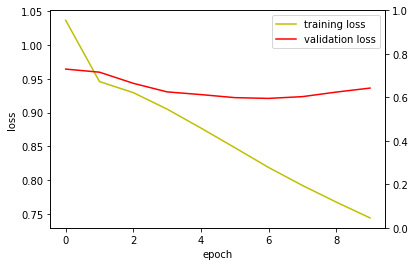

In [22]:
# training loss와 validation loss

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='training loss')
loss_ax.plot(history.history['val_loss'], 'r', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper right')

plt.show()

### 참고. MF와 성능 비교

In [23]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
# surprise에서 제공하는 dataset과 reader

from surprise import Reader, Dataset

reader = Reader(rating_scale=(1.0, 5.0))
data = Dataset.load_from_df(ratings_df[['user_id', 'movie_id', 'rating']], reader)

In [25]:
from surprise import accuracy
from surprise.model_selection import train_test_split

# train / test 데이터 나누기
train_data, test_data = train_test_split(data, test_size=0.2, random_state=10)

In [26]:
from surprise import SVD

svd_model = SVD(n_factors=50, reg_all = 0.02)

# 학습데이터를 가지고 모델 학습
svd_model.fit(train_data)

# 테스트 데이터로 모델의 예측 평점을 추론
predictions = svd_model.test(test_data)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.9247


0.9246706829320045

## FM으로 유저 추천 제공
- 유저를 기준으로 Top N개의 영화를 추천하는 시나리오를 구현해봅시다.
- 유저에 해당하는 FM의 variable은 고정으로 두고, 영화에 해당하는 variable을 사용해서 여러 개의 영화에 대한 평점을 FM으로 예측한다.
- 예측 평점을 기준으로 정렬하여 가장 평점을 가진 영화를 추천한다.

In [27]:
# 100번 유저 추천 예시
users_df.loc[100]

user_id           101
age                10
gender              M
occupation    student
zip_code        05146
Name: 100, dtype: object

In [28]:
user_series = users_df.loc[100]
user_idx = user_id_map[user_series['user_id']]
gender_idx = gender_map[user_series['gender']]
age_idx = age_map[user_series['age']]

In [29]:
# 모든 영화에 대해 FM으로 평점을 예측하기 위해 X 생성
movie_ids = []
X = []

for _, row in movies_df.iterrows():

  movie_id = row['movie_id']
  movie_ids.append(movie_id)

  x = [0] * size_X
  
  # user variable은 같은 값을 사용
  idx=0
  x[idx + user_idx] = 1
  idx += len(user_id_map)

  x[idx + gender_idx] = 1
  idx += len(gender_map)

  x[idx + age_idx] = 1
  idx += len(age_map)

  movie_idx = movie_id_map[movie_id]
  x[idx + movie_idx] = 1
  idx += len(movie_id_map)

  # genre feature는 multi-hot encoding
  x[idx : idx+len(genre_list)] = row[genre_list]
  X.append(x)

X = np.asarray(X)

print(len(X))

1682


In [30]:
pred_ratings = fm.predict(X)
pred_ratings

53/53 [==============================] - 0s 5ms/step


array([[3.3087149],
       [3.1706955],
       [2.8060381],
       ...,
       [2.2218342],
       [2.4427583],
       [2.4909687]], dtype=float32)

In [31]:
user_ratings = [(movie_id, pred_rating[0]) for movie_id, pred_rating in zip(movie_ids, pred_ratings)]
user_ratings

[(1, 3.3087149),
 (2, 3.1706955),
 (3, 2.8060381),
 (4, 2.6658995),
 (5, 2.8085752),
 (6, 2.6321123),
 (7, 2.725797),
 (8, 3.1987033),
 (9, 2.176238),
 (10, 1.9985831),
 (11, 3.4088676),
 (12, 2.5541582),
 (13, 2.3443499),
 (14, 2.3075795),
 (15, 3.7017279),
 (16, 2.7258873),
 (17, 2.5726762),
 (18, 2.343222),
 (19, 2.7096148),
 (20, 2.2923026),
 (21, 2.8010879),
 (22, 4.011571),
 (23, 2.4948053),
 (24, 3.307197),
 (25, 2.374377),
 (26, 2.6028342),
 (27, 3.0736349),
 (28, 3.1448298),
 (29, 2.5748158),
 (30, 2.7659469),
 (31, 3.3189166),
 (32, 2.4181163),
 (33, 3.0219288),
 (34, 2.7218852),
 (35, 2.315984),
 (36, 2.3596802),
 (37, 2.2423496),
 (38, 2.6240313),
 (39, 2.4172032),
 (40, 2.0718455),
 (41, 2.7222884),
 (42, 2.8220778),
 (43, 2.6519656),
 (44, 2.703873),
 (45, 2.90444),
 (46, 2.7917132),
 (47, 2.474504),
 (48, 2.5151255),
 (49, 2.5295665),
 (50, 4.258168),
 (51, 3.6806486),
 (52, 2.4815016),
 (53, 1.8669176),
 (54, 3.226583),
 (55, 2.8166454),
 (56, 3.3521972),
 (57, 2.665432

In [32]:
# topN 추천
n = 10
topn = sorted(user_ratings, key=lambda x: (x[1]), reverse=True)[:10]
topn

[(313, 4.332247),
 (172, 4.3211775),
 (50, 4.258168),
 (181, 4.217048),
 (174, 4.1918855),
 (82, 4.048094),
 (22, 4.011571),
 (117, 3.9251068),
 (148, 3.9038444),
 (210, 3.8660636)]

# Xlearn으로 CTR 예측
- Xlearn에서 제공하는 FM 모델로 CTR을 예측해봅니다
- 주어진 avazu ctr prediction 데이터를 xlearn에 적합하게 변환합니다
- 모델의 성능은 분류 성능인 logloss로 평가합니다
- xlearn 최신 버전을 사용하기 위해선 `pip install xlearn` 대신에 직접 xlearn [최신 버전](https://github.com/aksnzhy/xlearn/releases/tag/v0.4.4)을 다운로드 받아서 설치합니다
- [xlearn 제공 예제](https://github.com/aksnzhy/xlearn/tree/master/demo/classification/criteo_ctr)

## 광고 데이터 특징

- 유저 식별자가 없습니다. 즉, 개별 유저에 대해서 추천을 진행할 때 유저 아이디를 사용하지 않습니다
- 대신에 다른 피쳐들이 존재합니다, 이를 유저 피쳐로 볼 수도 있고 컨텍스트 피쳐로 볼 수도 있다. 이런 피쳐를 사용하여 클릭 확률을 예측합니다
- 다른 데이터와 가장 큰 차이점은 유저에게 광고가 노출되었으나 클릭하지 않았다는 Non-click 데이터가 존재합니다. 기존에는 구매했다 혹은 클릭했다는 positive feedback만 존재했지만 이 데이터는 postive feedback과 negative feedback이 모두 존재합니다

In [33]:
file_path = '/content/drive/MyDrive/recomm_study/recomm_code/Recommend_learningspoons/data/avazu-ctr-prediction-20220921T022743Z-001/avazu-ctr-prediction/ad_click.csv'
parse_date = lambda x : datetime.strptime(x, '%y%m%d%H').strftime('%Y-%m-%d')
click_df = pd.read_csv(file_path, parse_dates = ['datetime'], date_parser = parse_date, header=0)
print(click_df.shape)
click_df.head()

(200000, 24)


,id,click,datetime,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10019071520499579916,0,2014-10-21,1005,0,da79c793,71ed77a0,f028772b,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157
1,10025633842336165171,0,2014-10-21,1010,1,85f751fd,c4e18dd6,50e219e0,8c0dcd5a,7801e8d9,...,4,0,21665,320,50,2493,3,35,-1,117
2,10092735447533755726,0,2014-10-21,1002,0,61a8c644,948ff336,50e219e0,ecad2386,7801e8d9,...,0,0,19665,320,50,2253,2,303,-1,52
3,10141326312159899433,1,2014-10-21,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,-1,79
4,10141793556467368079,0,2014-10-21,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,...,1,0,20362,320,50,2333,0,39,-1,157


### 데이터 로드

In [34]:
# 사용 가능한 피쳐 및 타겟 컬럼 확인
click_df.columns

Index(['id', 'click', 'datetime', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21'],
      dtype='object')

In [35]:
# 데이터의 unique count 확인
# id, device_ip, device_id와 같은 피쳐들은 사용하지 않습니다

click_df.apply(lambda x: len(x.unique())).sort_values(ascending=False)

id                  200000
device_ip           143725
device_id            33229
device_model          3751
C14                   1934
site_id               1804
app_id                1776
site_domain           1711
C17                    405
C20                    159
app_domain             112
C19                     65
C21                     60
app_category            22
site_category           20
datetime                10
C16                      9
C15                      8
C1                       7
banner_pos               7
device_type              4
device_conn_type         4
C18                      4
click                    2
dtype: int64

0    0.829755
1    0.170245
Name: click, dtype: float64


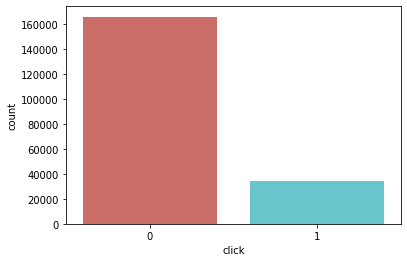

In [36]:
# 클릭(0/1)의 비율
print(click_df['click'].value_counts() / len(click_df))
sns.countplot(x='click', data=click_df, palette='hls')
plt.show()

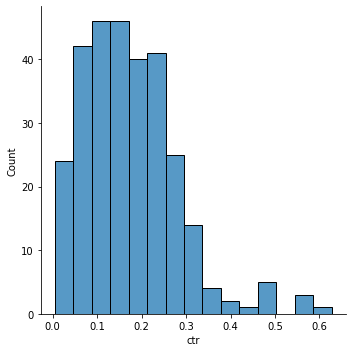

In [37]:
# 광고 소재(C14)별 CTR 분포
# imp : 해당 광고를 띄운 횟수
# click : 띄워진 광고를 보고 클릭을 한 횟수
# imp 100회 이상인 소재별 CTR 분포
creative_ctr = pd.DataFrame({
    'imp' : click_df.groupby('C14')['click'].count(),
    'click' : click_df.groupby('C14')['click'].sum()
}).reset_index()
creative_ctr['ctr'] = creative_ctr['click'] / creative_ctr['imp']

# imp가 100회 이상인 광고 소재별 CTR 분포
ax = sns.displot(creative_ctr[creative_ctr['imp'] >= 100]['ctr'])

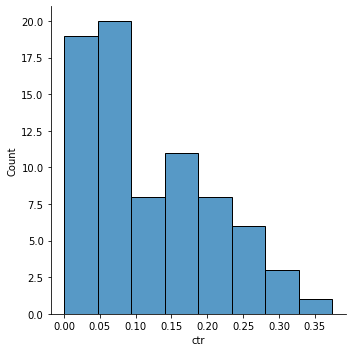

In [38]:
# 앱(app_id)별 CTR 분포

app_ctr = pd.DataFrame({
    'imp': click_df.groupby(['app_id'])['click'].count(),
    'click': click_df.groupby(['app_id'])['click'].sum()
}).reset_index()
app_ctr['ctr'] = app_ctr['click'] / app_ctr['imp']

# imp 100회 이상인 app_id의 ctr 분포
ax = sns.displot(app_ctr[app_ctr['imp'] >= 100]['ctr'])

### 데이터 가공

In [39]:
click_df = click_df[[
    'click', 'datetime', 'banner_pos', 'site_id', 'site_domain',
    'site_category', 'app_id', 'app_domain', 'app_category',
    'device_model', 'device_type', 'device_conn_type',
    'C1', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21'
]]

In [40]:
# FM에 사용할 variables
feature_col = [
    'banner_pos', 'site_id', 'site_domain','site_category', 'app_id', 'app_domain',
    'app_category', 'device_model', 'device_type', 'device_conn_type',
    'C1', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21'
]

for feature in feature_col:
  click_df[feature] = click_df[feature].astype('category')
  click_df[feature] = click_df[feature].cat.codes

click_df

,click,datetime,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_model,...,device_conn_type,C1,C14,C15,C16,C17,C18,C19,C20,C21
0,0,2014-10-21,0,1546,767,18,1648,43,0,3696,...,0,2,375,3,2,102,0,2,0,42
1,0,2014-10-21,1,949,1316,5,965,43,3,441,...,0,5,719,3,2,196,3,2,0,39
2,0,2014-10-21,0,706,1001,5,1648,43,0,1676,...,0,1,410,3,2,116,2,21,0,15
3,1,2014-10-21,1,1541,1029,18,1648,43,0,2011,...,0,2,202,3,2,51,0,2,0,22
4,0,2014-10-21,0,617,1338,3,1648,43,0,3004,...,0,2,515,3,2,144,0,4,0,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0,2014-10-30,1,647,604,18,1648,43,0,1272,...,0,2,1771,3,2,378,3,8,0,6
199996,0,2014-10-30,0,949,1316,5,564,91,3,2240,...,0,2,759,3,2,201,3,5,81,16
199997,0,2014-10-30,0,217,1620,1,1648,43,0,235,...,0,2,1272,3,2,294,0,2,0,14
199998,0,2014-10-30,0,1361,1251,5,1648,43,0,121,...,0,1,291,3,2,91,2,4,56,7


In [41]:
# feature dimension size
feature_dim = {}

for feature in feature_col:
  feature_dim[feature] = click_df[feature].nunique()

feature_dim

{'banner_pos': 7,
 'site_id': 1804,
 'site_domain': 1711,
 'site_category': 20,
 'app_id': 1776,
 'app_domain': 112,
 'app_category': 22,
 'device_model': 3751,
 'device_type': 4,
 'device_conn_type': 4,
 'C1': 7,
 'C14': 1934,
 'C15': 8,
 'C16': 9,
 'C17': 405,
 'C18': 4,
 'C19': 65,
 'C20': 159,
 'C21': 60}

In [42]:
print('number of variables:', sum([dim for dim in feature_dim.values()]))

number of variables: 11862


In [43]:
# 전체 데이터를 FM의 variable number로 변환
# 각 row/col의 데이터별로 feature_dim의 value값 합산
idx = 0

for feature in feature_col:
  click_df[feature] = click_df[feature] + idx
  idx += feature_dim[feature]

click_df

,click,datetime,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_model,...,device_conn_type,C1,C14,C15,C16,C17,C18,C19,C20,C21
0,0,2014-10-21,0,1553,2578,3540,5190,5361,5430,9148,...,9207,9213,9593,11155,11162,11271,11574,11580,11643,11844
1,0,2014-10-21,1,956,3127,3527,4507,5361,5433,5893,...,9207,9216,9937,11155,11162,11365,11577,11580,11643,11841
2,0,2014-10-21,0,713,2812,3527,5190,5361,5430,7128,...,9207,9212,9628,11155,11162,11285,11576,11599,11643,11817
3,1,2014-10-21,1,1548,2840,3540,5190,5361,5430,7463,...,9207,9213,9420,11155,11162,11220,11574,11580,11643,11824
4,0,2014-10-21,0,624,3149,3525,5190,5361,5430,8456,...,9207,9213,9733,11155,11162,11313,11574,11582,11643,11844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0,2014-10-30,1,654,2415,3540,5190,5361,5430,6724,...,9207,9213,10989,11155,11162,11547,11577,11586,11643,11808
199996,0,2014-10-30,0,956,3127,3527,4106,5409,5433,7692,...,9207,9213,9977,11155,11162,11370,11577,11583,11724,11818
199997,0,2014-10-30,0,224,3431,3523,5190,5361,5430,5687,...,9207,9213,10490,11155,11162,11463,11574,11580,11643,11816
199998,0,2014-10-30,0,1368,3062,3527,5190,5361,5430,5573,...,9207,9212,9509,11155,11162,11260,11576,11582,11699,11809


### train / test 데이터 생성

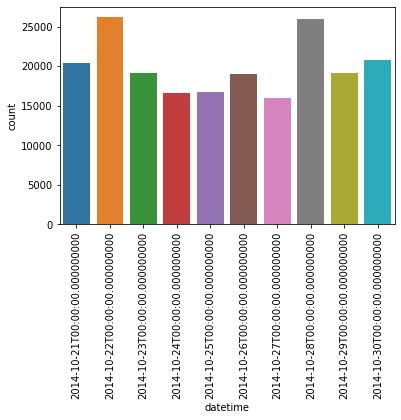

In [44]:
g = sns.countplot(x='datetime', data=click_df)
plt.xticks(rotation=90)
plt.show()

In [45]:
# datetime을 기준으로 train_test_split
# 2014-10-28
train = click_df[click_df['datetime'] <= '2014-10-28']
test = click_df[click_df['datetime'] > '2014-10-28']
print(len(train))
print(len(test))

160052
39948


In [46]:
# Xlearn의 fm데이터는 ylabel index_1:value_1 index_2:value_2 ... 형태로 만들어야
with open('./fm_train.txt', 'w') as f:
  
  for _, row in tqdm(train.iterrows()):
    label = row['click']
    feature = [str(label)] + [str(elem) + ':1.0' for elem in row[feature_col].values]
    f.write(' '.join(feature) + '\n')

with open('./fm_test.txt', 'w') as f:
    for _, row in tqdm(test.iterrows()):
        label = row['click']
        feature = [str(label)]+ [str(elem) + ':1.0' for elem in row[feature_col].values]
        f.write(' '.join(feature) + '\n')

0it [00:00, ?it/s]

0it [00:00, ?it/s]

## xlearn FM
- xlearn의 경우 command line 혹은 python console로 실행할 때 학습 진행 상황 및 training loss, validation loss가 출력됩니다
- jupyte notebook에 코드를 적어놓았지만 실제 실행은 python console에서 진행합니다
- 참고: xlearn 모델 관련 [하이퍼파라미터](https://xlearn-doc.readthedocs.io/en/latest/all_api/index.html?highlight=create_fm#xlearn-python-api)

In [2]:
import xlearn as xl
import os
os.environ['USER'] = 'test'
xl.hello()

In [3]:
# FM 모델 선언
fm_model = xl.create_fm()
fm_model.setTrain('/content/fm_train.txt')
fm_model.setValidate('/content/fm_test.txt')

param = {'task' : 'binary', 'lr' : 0.2, 'lambda' : 0.002, 'k' : 20, 'epoch' : 10, 'nthread' : 20}
fm_model.setTXTModel('./fm_model.txt')
fm_model.fit(param, './fm_model.out')

In [ ]:
# TEST --> output.txt
fm_model.setTest('./fm_test.txt')
fm_model.setSigmoid()
fm_model.predict('./fm_test.out', './fm_output.txt')

In [ ]:
!head fm_output.txt

0.282623
0.0369239
0.0426009
0.129193
0.13478
0.477734
0.280125
0.257084
0.0624865
0.217118


### 하이퍼 파라미터 튜닝

In [ ]:
from sklearn.metrics import log_loss

test_click = test_df['click'].values

result = []

for k in [10, 20, 30, 50]:
    for _lambda in [0.001, 0.002, 0.005]:
        for lr in [0.1, 0.2, 0.3]:
            
            # train
            fm_model = xl.create_fm()         
            fm_model.setTrain("./fm_train.txt")
            param = {'task':'binary', 'lr':lr, 'lambda': _lambda, 'k': k, 'epoch': 30}
            fm_model.fit(param, "./fm_model.out")
            
            # test
            fm_model.setTest("./fm_test.txt")
            fm_model.setSigmoid()
            pCTR = fm_model.predict("./fm_model.out")
            result.append([k, _lambda, lr, log_loss(test_click, pCTR)])
            print(k, _lambda, lr, log_loss(test_click, pCTR))
            
result_df = pd.DataFrame(result, columns = ['k', 'lambda', 'lr', 'logloss'])

10 0.001 0.1 0.4032673406709089
10 0.001 0.2 0.4027625747544948
10 0.001 0.3 0.40308110551488785
10 0.002 0.1 0.40360177897533833
10 0.002 0.2 0.4029375336563448
10 0.002 0.3 0.40310366784318336
10 0.005 0.1 0.4052613930601119
10 0.005 0.2 0.40449231814861086
10 0.005 0.3 0.4044953158049373
20 0.001 0.1 0.4032305946728742
20 0.001 0.2 0.4027536842836286
20 0.001 0.3 0.40307589667912236
20 0.002 0.1 0.4035968778675589
20 0.002 0.2 0.4029323989789461
20 0.002 0.3 0.4031462859712018
20 0.005 0.1 0.4052441484354794
20 0.005 0.2 0.4045017438244473
20 0.005 0.3 0.40451143276858587
30 0.001 0.1 0.403225120241526
30 0.001 0.2 0.40275668314935953
30 0.001 0.3 0.40308156934387235
30 0.002 0.1 0.40359150349264444
30 0.002 0.2 0.4029391906181994
30 0.002 0.3 0.4031020103717218
30 0.005 0.1 0.40523825987596807
30 0.005 0.2 0.4044981032233755
30 0.005 0.3 0.4044944530944084
50 0.001 0.1 0.4032273820786605
50 0.001 0.2 0.4027640932483963
50 0.001 0.3 0.4030821361645374
50 0.002 0.1 0.4035975043771931

In [ ]:
result_df.sort_values(by='logloss')

,k,lambda,lr,logloss
10,20,0.001,0.2,0.402754
19,30,0.001,0.2,0.402757
1,10,0.001,0.2,0.402763
28,50,0.001,0.2,0.402764
13,20,0.002,0.2,0.402932
31,50,0.002,0.2,0.402933
4,10,0.002,0.2,0.402938
22,30,0.002,0.2,0.402939
11,20,0.001,0.3,0.403076
2,10,0.001,0.3,0.403081
